In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
import cv2
from math import pi, ceil, floor

#path = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
path = "./test/images/blood_smear_9.JPG"


In [9]:
def getImage(mode=0, size=(640,480)):
    img = cv2.imread(path,mode)
    return cv2.resize(img,size)

def applyBlur(img, k=9):
    return cv2.GaussianBlur(img,(k,k),0)

def otsu(img,block=81,offset=0.3):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def adaptativeThresh(img,block=121,offset=0):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def fillHoles(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    thresh_filled = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    color = 255
    for i in range(len(contours)):
        cv2.drawContours(thresh_filled, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    return thresh_filled

def connectedComponents(thresh):
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    labeled_img_rgb = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
    return labeled_img_rgb, numLabels, labels, stats, centroids


def erode(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.erode(src, element)
    
def dilate(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.dilate(src, element)




def getPrincipalComponents(img):
    # Connected components with stats.
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)

    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])
    
    img2 = np.zeros(output.shape, dtype='uint8')
    img2[output == max_label] = 255
    return img2

In [10]:
MIN_CELL_AREA = 500
MAX_CELL_AREA = 2300



def markCells(img, mask, cellsColor=(255,255,255), size=5):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)

    for i in range(1, numLabels):
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        #get area
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        #print(minArea, area, maxArea) minArea=MIN_CELL_AREA, maxArea=MAX_CELL_AREA
        if MIN_CELL_AREA < area < MAX_CELL_AREA:
            cv2.circle(img, (int(cX), int(cY)), size, (0,0,0), -1)
            cv2.circle(img, (int(cX), int(cY)), size-1, cellsColor, -1)
        
        if MAX_CELL_AREA < area:
            est = ceil(area/MAX_CELL_AREA)
            cv2.circle(img, (int(cX)-7, int(cY)), size, (0,0,0), -1)
            cv2.circle(img, (int(cX)-7, int(cY)), size-1, cellsColor, -1)
            cv2.putText(img, str(est), (int(cX), int(cY)+4), cv2.FONT_HERSHEY_SIMPLEX,
                        .5, (0,0,0), 6, cv2.LINE_AA)
            cv2.putText(img, str(est), (int(cX), int(cY)+5), cv2.FONT_HERSHEY_SIMPLEX,
                        .5, (255,255,255), 2, cv2.LINE_AA)
            
            cv2.rectangle(img, (x,y), (x+w,y+h), cellsColor, 1)
 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def breakBigGroups(mask,_erode=15,_dilate=11):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        cut = cut.copy()

        if MAX_CELL_AREA < area:
            cut_bk = cut.copy()
            cut = getPrincipalComponents(cut)

            #remove the group from original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask[ cell_on_original_size == 255 ] = 0

            #work on group
            #cut = cv2.erode(cut, kernel, iterations=1)
            cut = erode(cut,_erode)
            cut = dilate(cut,_dilate)

            #return the eroded and marked group to original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask += cell_on_original_size
    
    return mask


In [11]:
def random_color():
    color = tuple(np.random.randint(256, size=3))
    if (color[0] < 100 and color[1] < 100 and color[2] < 100):
        return random_color()
    elif (color[0] > 230 and color[1] > 230 and color[2] > 230):
        return random_color()
    else:
        return color

def shuffleColors(img):
    
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])

    shape = img.shape
    reshapedImg = img.reshape(1,shape[0]*shape[1],3)[0]
    colors = np.unique(reshapedImg, axis=0)
    colors = np.delete(colors,0,axis=0)
    
    labeled_img_rgb3 = img.copy()

    for color in colors:
        newColor = random_color()

        red, green, blue = labeled_img_rgb3.T 
        selected_color = (red == color[0]) & (green == color[1]) & (blue == color[2])
        labeled_img_rgb3[selected_color.T] = newColor
    return labeled_img_rgb3


def colorize(img):
    labeled_rgb, numLabels, labels, stats, centroids = connectedComponents(img)
    return shuffleColors(labeled_rgb)

In [12]:
def hsvMask(img, fromColor=(110,0,0),toColor=(150,255,255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, fromColor, toColor)
    mask_dilated = mask.copy()
    #erode
    kernel = np.ones((3, 3), np.uint8)
    mask_dilated = cv2.erode(mask_dilated, kernel)
    #dilate
    kernel = np.ones((15, 15), np.uint8)
    mask_dilated = cv2.dilate(mask_dilated, kernel)

    return mask, mask_dilated

def removeParasites(img,mask):
    img[mask == 255] = 0
    img = erode(img,2)
    img = dilate(img,2)
    return img

def markParasites(img, mask, cell_mask, external_infection_color=(0, 220, 240), inside_infection_color=(171,0,171)):
    labeled_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)
    
    _, _, _, cell_stats, _ = connectedComponents(cell_mask)
    
    #remove the parasites from cell mask
    #cell_mask[mask==255] = 0
    #cell_mask = fillHoles(cell_mask)
    
    for i in range(1, numLabels):
        area = stats[i, cv2.CC_STAT_AREA]
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        (cX, cY) = centroids[i]
        
        color = external_infection_color
        for cell_stat in cell_stats:
            cellArea  = cell_stat[cv2.CC_STAT_AREA]
            cellX = cell_stat[cv2.CC_STAT_LEFT]
            cellY = cell_stat[cv2.CC_STAT_TOP]
            cellW = cell_stat[cv2.CC_STAT_WIDTH]
            cellH = cell_stat[cv2.CC_STAT_HEIGHT]
            
            if MIN_CELL_AREA < cellArea < MAX_CELL_AREA*10:
                if cellX < cX < cellX+cellW and cellY < cY < cellY+cellH:
                    color = inside_infection_color
                    cv2.rectangle(img, (cellX,cellY), (cellX+cellW,cellY+cellH), (0,255,0), 1)
                    break
        
        
#         area_median = np.median(cell_mask[int(cY)-3:int(cY)+3,int(cX)-3:int(cX)+3])
#         #if cell_mask[int(cY),int(cX)] == 255:
#         if area_median > 0:
#             color = inside_infection_color
#         else:
#             color = external_infection_color
#             cv2.circle(img, (int(cX), int(cY)), 3, (255,0,0), -1)
        
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 1)
        
    return img


# OTSU

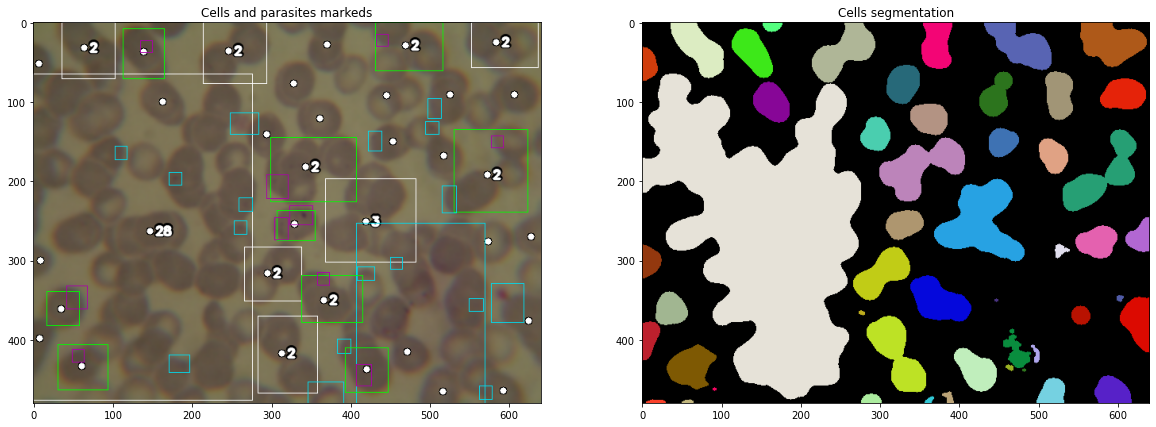

In [13]:

#read in grayscale
imgGS = getImage()
#read in colors
img = getImage(mode=1)

#apply blur
imgGS = applyBlur(imgGS)
img = applyBlur(img)

#otsu adaptative
cell_mask = otsu(imgGS)

#hsv mask
par_mask, par_mask_dilated = hsvMask(img)

#remove parasites from otsu
cell_mask = removeParasites(cell_mask,par_mask)

#fill holes
cell_mask = fillHoles(cell_mask)

#break gorup of cells
cell_mask = breakBigGroups(cell_mask)

#colorize the cells
cell_mask_colored = colorize(cell_mask)

#mark
img = markCells(img, cell_mask)
img = markParasites(img, par_mask_dilated, cell_mask)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Cells and parasites markeds")
ax[1].imshow(cell_mask_colored, cmap='gray')
ax[1].set_title("Cells segmentation")
plt.show()

# OTSU without blur

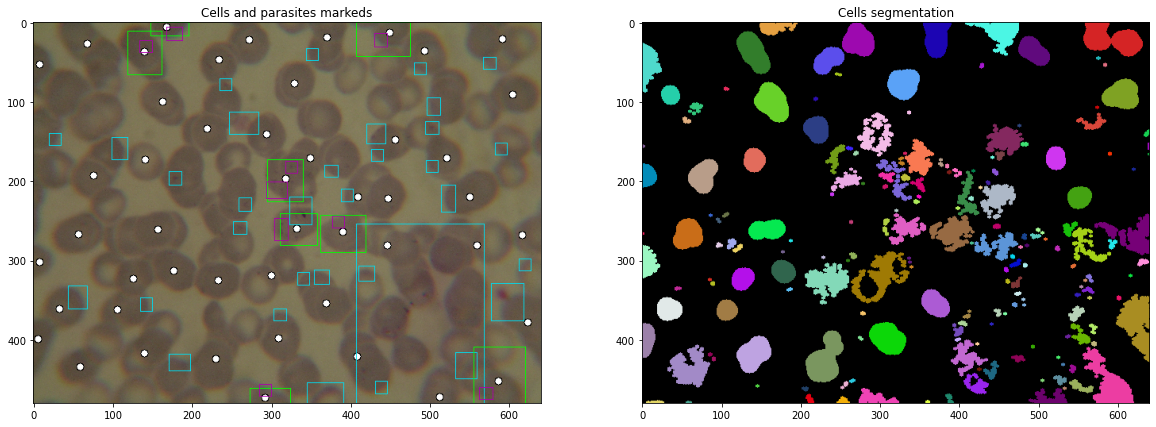

In [14]:

#read in grayscale
imgGS = getImage()
#read in colors
img = getImage(mode=1)

#shifted = cv2.pyrMeanShiftFiltering(img, 3, 5)
#imgGS = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

#otsu adaptative
cell_mask = otsu(imgGS)

#hsv parasite mask
par_mask, par_mask_dilated = hsvMask(img)

#remove parasites from otsu
cell_mask = removeParasites(cell_mask,par_mask)

#fill holes
cell_mask = fillHoles(cell_mask)

#break gorup of cells
cell_mask = breakBigGroups(cell_mask)

#colorize the cells
cell_mask_colored = colorize(cell_mask)

#mark
img = markCells(img, cell_mask)
img = markParasites(img, par_mask_dilated, cell_mask)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))


ax[0].imshow(img, cmap='gray')
ax[0].set_title("Cells and parasites markeds")
ax[1].imshow(cell_mask_colored, cmap='gray')
ax[1].set_title("Cells segmentation")
plt.show()



# HSV

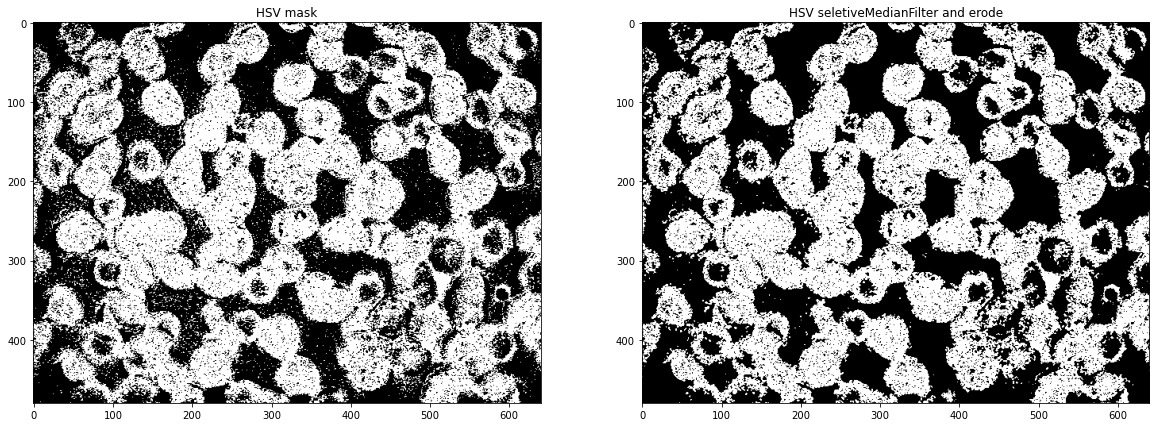

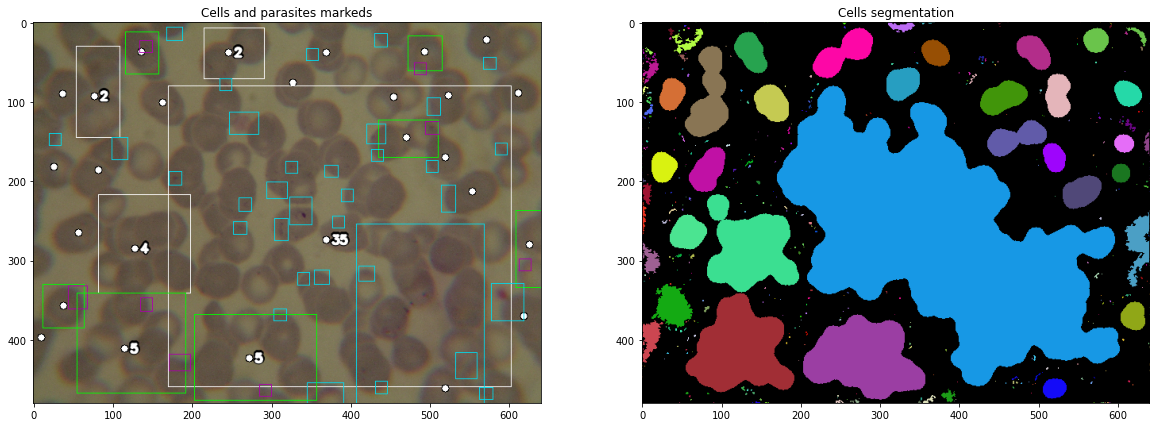

In [15]:
def cellHSVMask(img, fromColor=(100,0,0),toColor=(130,110,255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, fromColor, toColor)

    return mask

def seletiveMedianFilter(img, kernel_size):
        
    new_img = img.copy()
    divided = floor(kernel_size/2)
    
    for i in range(divided,img.shape[0]-divided,1):
        for j in range(divided,img.shape[1]-divided,1):
            space = img[i-divided:i+divided+1,j-divided:j+divided+1]
            if np.median(space) == 0:
                new_img[i,j] = np.median(space)
            
    return new_img

#read in grayscale
imgGS = getImage()
#read in colors
img = getImage(mode=1)

#apply blur
#imgGS = applyBlur(imgGS)
#img = applyBlur(img,7)


#otsu adaptative
#cell_mask = otsu(imgGS)
cell_mask = cellHSVMask(img,fromColor=(100,0,0),toColor=(110,100,200))
#cell_mask = cv2.medianBlur(cell_mask, 5)

cell_mask_bk = cell_mask.copy()

# plt.figure(figsize=(10,10))
# plt.imshow(cell_mask)
# plt.show()


cell_mask = seletiveMedianFilter(cell_mask,3)

#cell_mask = medianFilter(cell_mask,15)
#cell_mask = erode(cell_mask,1)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

ax[0].imshow(cell_mask_bk, cmap='gray')
ax[0].set_title("HSV mask")
ax[1].imshow(cell_mask, cmap='gray')
ax[1].set_title("HSV seletiveMedianFilter and erode")
plt.show()


#fill holes
cell_mask = fillHoles(cell_mask)

#break gorup of cells
cell_mask = breakBigGroups(cell_mask)

#colorize the cells
cell_mask_colored = colorize(cell_mask)


#mark
img = markCells(img, cell_mask)
img = markParasites(img, par_mask_dilated, cell_mask)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Cells and parasites markeds")
ax[1].imshow(cell_mask_colored, cmap='gray')
ax[1].set_title("Cells segmentation")
plt.show()


# HSV Without erode

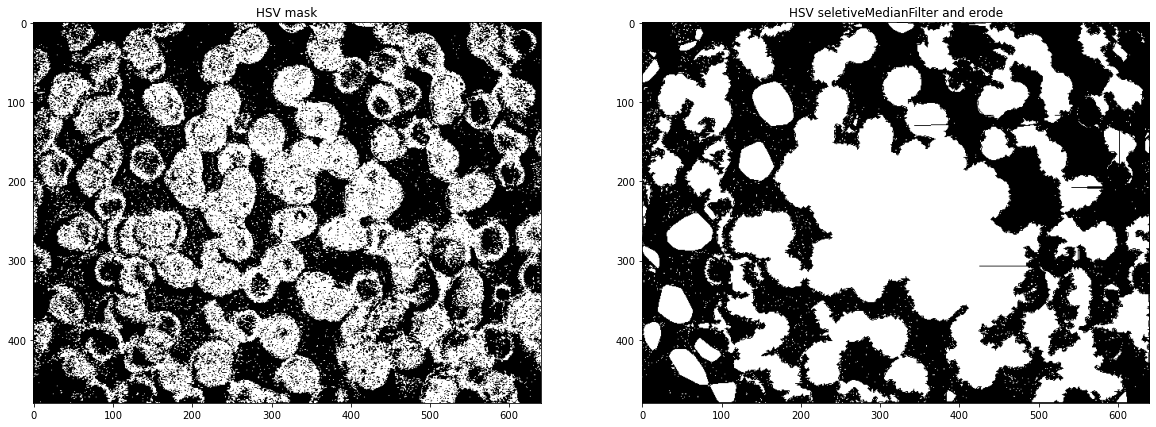

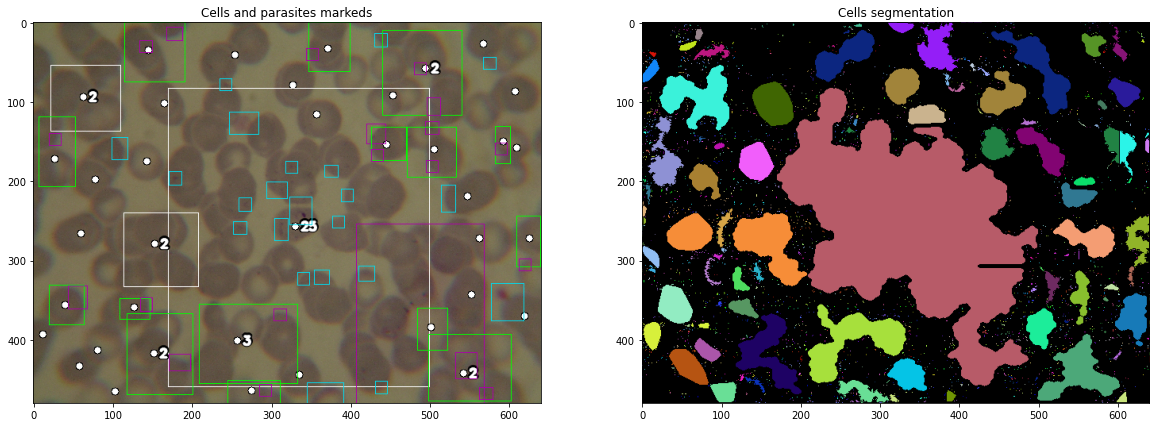

In [16]:
def mergeCellsParts(mask):
    
    mask = mask.copy()
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        
        
        if 50 < area < MAX_CELL_AREA:
            thresh_filled = cut
                
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            hull = []
            for y in range(len(contours)):
                hull.append(cv2.convexHull(contours[y], False))    
            cv2.drawContours(thresh_filled, hull, -1, 255, 1, 8)
            
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(thresh_filled, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
        elif MAX_CELL_AREA < area:
            
            #preenche
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
            #erode as bordas
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 100, 1, cv2.LINE_8, hierarchy, 0)
            
            
            #nao deixa apagar nas bordas do corte
            for x in range(cut.shape[0]):
                if (cut[x,0] == 100):
                    cut[x,0] = 255
                if (cut[x,cut.shape[1]-1] == 1):
                    cut[x,cut.shape[1]-1] = 255
            for y in range(cut.shape[1]):
                if (cut[0,y] == 100):
                    cut[0,y] = 255
                if (cut[cut.shape[0]-1,y] == 1):
                    cut[cut.shape[0]-1,y] = 255
                    
            cut[cut == 100] = 0
            
            #cut[True] = mergeCellsParts(cut)
            
            #plt.figure(figsize=(10,10))
            #plt.imshow(cut)
            #plt.show()
        
    return mask
            

#MIN_CELL_AREA = 2000
#MAX_CELL_AREA = 6200


#read in grayscale
imgGS = getImage()
#read in colors
img = getImage(mode=1)

#otsu adaptative
#cell_mask = otsu(imgGS)
cell_mask = cellHSVMask(img,fromColor=(100,0,0),toColor=(110,84,143))
#cell_mask = cv2.medianBlur(cell_mask, 5)

#hsv parasite mask
par_mask, par_mask_dilated = hsvMask(img)

cell_mask_bk = cell_mask.copy()
cell_mask = mergeCellsParts(cell_mask)
#plt.figure(figsize=(10,10))
#plt.imshow(cell_mask)
#plt.show()


fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

ax[0].imshow(cell_mask_bk, cmap='gray')
ax[0].set_title("HSV mask")
ax[1].imshow(cell_mask, cmap='gray')
ax[1].set_title("HSV seletiveMedianFilter and erode")
plt.show()


# # #fill holes
# cell_mask = fillHoles(cell_mask)

# # #break gorup of cells
cell_mask = breakBigGroups(cell_mask,_erode=5,_dilate=3)

# # #colorize the cells
cell_mask_colored = colorize(cell_mask)

#plt.figure(figsize=(10,10))
#plt.imshow(cell_mask_colored)
#plt.show()

#mark
img = markCells(img, cell_mask)
img = markParasites(img, par_mask_dilated, cell_mask)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Cells and parasites markeds")
ax[1].imshow(cell_mask_colored, cmap='gray')
ax[1].set_title("Cells segmentation")
plt.show()


# Watershed

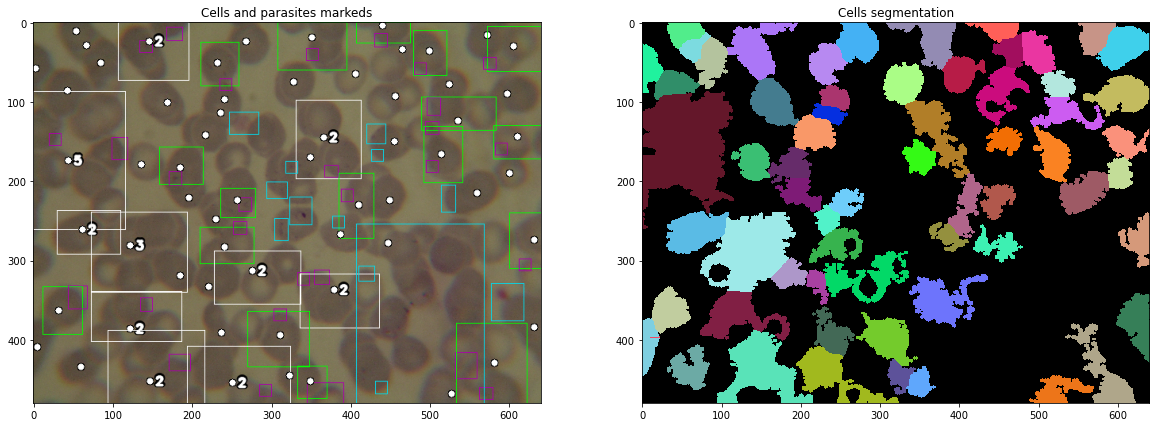

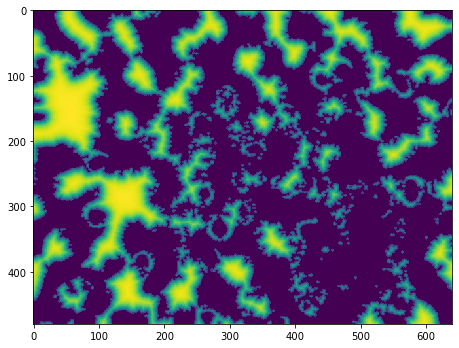

In [17]:
#https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
#https://docs.opencv.org/4.5.3/dd/d49/tutorial_py_contour_features.html

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
from skimage import measure
from skimage.segmentation import random_walker

MAX_CELL_AREA = 2700

def applyWatershed(cell_mask):
    D = ndimage.distance_transform_edt(cell_mask)
    
    localMax = peak_local_max(D, min_distance=10, 
                                  #threshold_rel=0,
                                  #exclude_border=True,
                                  threshold_abs=10, 
                                  labels=cell_mask)
    
    peak_mask = np.zeros_like(cell_mask, dtype=bool)
    peak_mask[tuple(localMax.T)] = True
    

    markers = ndimage.label(peak_mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=cell_mask)
    return labels, D


def watershedMarkCellsAndParasites(img, labels, 
                                   parasites=None, 
                                   cellsColor=(255,255,255), 
                                   size=5, 
                                   external_infection_color=(0, 220, 240), 
                                   inside_infection_color=(171,0,171)):
    
    if type(parasites) != None:
        parLabeled_rgb, parNumLabels, parLabels, parStats, parCentroids = connectedComponents(parasites)
        parPrinted = []
    else:
        parLabeled_rgb, parNumLabels, parLabels, parStats, parCentroids = [], [], [], [], []
        parPrinted = []
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros((img.shape[0],img.shape[1]), dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        
        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        # draw a circle enclosing the object
        ((cX, cY), r) = cv2.minEnclosingCircle(c)      
        x,y,w,h = cv2.boundingRect(c)
        
        
        if MIN_CELL_AREA < area:
            for i in range(1,len(parCentroids),1):
                if i in parPrinted:
                    continue
                parC = parCentroids[i]
                if x < parC[0] < x+w and y < parC[1] < y+h:
                    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 1)
                    pX = parStats[i, cv2.CC_STAT_LEFT]
                    pY = parStats[i, cv2.CC_STAT_TOP]
                    pW = parStats[i, cv2.CC_STAT_WIDTH]
                    pH = parStats[i, cv2.CC_STAT_HEIGHT]
                    cv2.rectangle(img, (pX,pY), (pX+pW,pY+pH), inside_infection_color, 1)
                    parPrinted.append(i)
        
        
        if MIN_CELL_AREA < area < MAX_CELL_AREA:
            cv2.circle(img, (int(cX), int(cY)), size, (0,0,0), -1)
            cv2.circle(img, (int(cX), int(cY)), size-1, cellsColor, -1)
        
        if MAX_CELL_AREA < area:
            est = ceil(area/MAX_CELL_AREA)
            cv2.circle(img, (int(cX)-7, int(cY)), size, (0,0,0), -1)
            cv2.circle(img, (int(cX)-7, int(cY)), size-1, cellsColor, -1)
            cv2.putText(img, str(est), (int(cX), int(cY)+4), cv2.FONT_HERSHEY_SIMPLEX,
                        .5, (0,0,0), 6, cv2.LINE_AA)
            cv2.putText(img, str(est), (int(cX), int(cY)+5), cv2.FONT_HERSHEY_SIMPLEX,
                        .5, (255,255,255), 2, cv2.LINE_AA)
            cv2.rectangle(img, (x,y) , (x+w,y+h) , cellsColor, 1)
    
    
    
    #pinta o restante dos parasitas que nao estavam dentro das celulas
    for i in range(1, parNumLabels):
        if i in parPrinted:
            continue
        x = parStats[i, cv2.CC_STAT_LEFT]
        y = parStats[i, cv2.CC_STAT_TOP]
        w = parStats[i, cv2.CC_STAT_WIDTH]
        h = parStats[i, cv2.CC_STAT_HEIGHT]
        cv2.rectangle(img, (x,y), (x+w,y+h), external_infection_color, 1)
    
    return img



#read in grayscale
imgGS = getImage()
#read in colors
img = getImage(mode=1)


imgB = cv2.pyrMeanShiftFiltering(img, 3, 10)
imgGS = cv2.cvtColor(imgB,cv2.COLOR_BGR2GRAY)

#otsu adaptative
cell_mask = otsu(imgGS)

#hsv parasite mask
par_mask, par_mask_dilated = hsvMask(img)

#remove parasites from otsu
cell_mask = removeParasites(cell_mask,par_mask)

#fill holes
cell_mask = fillHoles(cell_mask)

# watershed
labels, D = applyWatershed(cell_mask)

# mark
img = watershedMarkCellsAndParasites(img, labels, par_mask_dilated)

# shuffle colors
labels = shuffleColors(labels)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))


#ax[0].imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')
ax[0].imshow(img)
ax[0].set_title("Cells and parasites markeds")
#ax[1].imshow(labels_rw, cmap='nipy_spectral', interpolation='nearest')
ax[1].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
ax[1].set_title("Cells segmentation")
plt.show()

plt.figure(figsize=(7.5,7.5))
plt.imshow(cv2.equalizeHist(D.astype('uint8')), interpolation='nearest')
plt.show()




# HoughCircles

In [18]:
# https://www.programcreek.com/python/example/110725/cv2.pyrMeanShiftFiltering
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


def hough_circles(gray,imgBGR,dp,minDist,param1,param2,minRadius,maxRadius):
    imgBGR = imgBGR.copy()
    #dst = cv2.pyrMeanShiftFiltering(imgBGR, 3, 5)
    #cimage = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    cimage = gray
    circles = cv2.HoughCircles(cimage, cv2.HOUGH_GRADIENT, 
                                dp=dp,
                                minDist=minDist, 
                                param1=param1, 
                                param2=param2, 
                                minRadius=minRadius, 
                                maxRadius=maxRadius)
    if circles is not None:
        print(len(circles[0]))
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(imgBGR, (i[0], i[1]), i[2], (0, 0, 255), 2)
            cv2.circle(imgBGR, (i[0], i[1]), 2, (255, 0, 255), 2)

        return imgBGR
    else:
        return imgBGR

img = cv2.cvtColor(getImage(mode=1), cv2.COLOR_BGR2RGB)
#img = img[0:256,0:256]
mask = otsu(imgGS)
mask = cv2.medianBlur(mask, 5)

@interact(dp=(0.01,20,.01), minDist=(1, 100, 1), param1=(1,100,1),
          param2=(1,100,1),minRadius=(0,1000,5),maxRadius=(0,1000,5))
def show_articles_more_than(dp=2.51, 
                            minDist=16,
                           param1=1,
                           param2=31,
                           minRadius=20,
                           maxRadius=30):
    img2 = hough_circles(mask, img,dp,minDist,param1,param2,minRadius,maxRadius)
    plt.imshow(img2)
    plt.show()

        

interactive(children=(FloatSlider(value=2.51, description='dp', max=20.0, min=0.01, step=0.01), IntSlider(valu…